# Cummulative Industry Exposure

In [1]:
# Import libraries

# System

import os

# Analysis

import numpy as np # Numerical Analysis
import pandas as pd # Data Mgmt
import geopandas as gpd # Spatial Data Mgmt
from scipy import interpolate as interp # # different interpolators
import rasterio # Rasters
from rasterio.transform import Affine
from rasterio import features

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [2]:
# Definitions

def save_geotiff(array, name, crs, resolution, minx, miny):
    '''Saves a numpy array into a geotiff.
    
    Give name as a string
    crs as int, resolution as int
    minx and miny both as floats
    '''
    transform = Affine.translation(minx - resolution / 2, miny - resolution / 2\
                              ) * Affine.scale(resolution, resolution)
    with rasterio.open(
        os.path.join(".", name + '.tif'),
        mode="w",
        driver="GTiff",
        height=array.shape[1],
        width=array.shape[0],
        count=1,
        dtype= 'float64',
        crs= rasterio.crs.CRS.from_epsg(crs),
        transform=transform,
    ) as new_dataset:
        new_dataset.write(array, 1)

In [13]:
# Load Data

# Minneapolis Boundary

mpls_path = os.path.join(os.getcwd(), '..', 'Data_IO', 'Data', 'mpls_boundary.geojson')
mpls = gpd.read_file(mpls_path)

# Average Annual Daily Traffic (AADT)

emissions_path = os.path.join(os.getcwd(), '..', 'Data_IO', 'Data', 'emissions.csv')
emissions = pd.read_csv(emissions_path)
emissions_geo = gpd.GeoDataFrame(emissions,
                                 crs = 'EPSG:26915',
                                 geometry = gpd.points_from_xy(x=emissions.EASTING,
                                                                 y=emissions.NORTHING)
                                )

In [14]:
emissions_geo.head()

,id,FACILITY_NAME,FACILITY_ID,PERMIT_TYPE,INDUSTRY_TYPE,NAICS_CODE,YEAR,POLLUTANT,LBS_EMITTED,TONS_EMITTED,EASTING,NORTHING,geometry
0,125759,Endres Processing LLC,3700280,R,Manufacturing,311119,2011,Trichlorofluoromethane,3.524000,1.762000e-03,499636.020348,4.955757e+06,POINT (499636.020 4955756.575)
1,125758,Endres Processing LLC,3700280,R,Manufacturing,311119,2011,Carbon Tetrachloride,0.687600,3.438000e-04,499636.020348,4.955757e+06,POINT (499636.020 4955756.575)
2,348025,Endres Processing LLC & Endres Farms,3700280,R,Manufacturing,311119,2017,Acrylonitrile,8.510000,4.255000e-03,499636.020348,4.955757e+06,POINT (499636.020 4955756.575)
3,348037,Endres Processing LLC & Endres Farms,3700280,R,Manufacturing,311119,2017,Benzo(K)Fluoranthene,0.000206,1.030354e-07,499636.020348,4.955757e+06,POINT (499636.020 4955756.575)
4,348036,Endres Processing LLC & Endres Farms,3700280,R,Manufacturing,311119,2017,Benzo(E)Pyrene,0.000005,2.472000e-09,499636.020348,4.955757e+06,POINT (499636.020 4955756.575)


In [18]:
np.unique(emissions_geo.POLLUTANT)

array(['1,1,1-Trichloroethane', '1,1,2,2-Tetrachloroethane',
       '1,1,2-Trichloroethane', '1,1-Dichloroethane',
       '1,2 trans - Dichloroethylene',
       '1,2,3,4,5,5-Hexachloro-1,3-Cyclopentadiene',
       '1,2,3,4,6,7,8- Heptachlorodibenzodioxin',
       '1,2,3,4,6,7,8-Heptachlorodibenzofuran',
       '1,2,3,4,7,8,9-Heptachlorodibenzofuran',
       '1,2,3,4,7,8-Hexachlorodibenzodioxin',
       '1,2,3,4,7,8-Hexachlorodibenzofuran',
       '1,2,3,6,7,8-Hexachlorodibenzodioxin',
       '1,2,3,6,7,8-Hexachlorodibenzofuran',
       '1,2,3,7,8,9-Hexachlorodibenzodioxin',
       '1,2,3,7,8,9-Hexachlorodibenzofuran',
       '1,2,3,7,8- Pentachlordibenzofuran',
       '1,2,3,7,8- Pentachlorodibenzodioxin', '1,2,4-Trichlorobenzene',
       '1,2,4-Trimethylbenzene', '1,2-Dibromoethane',
       '1,2-Dichloro-1,1,2,2-Tetrafluorethane', '1,2-Dichloroethane',
       '1,2-Dichloroethene',
       '1,2-Dichloroethylene, Mixture Of Cis And Trans',
       '1,2-Dimethoxyethane', '1,2-Epoxybutane',

## Prep

### Select

In [21]:
# Let's start with just the emissions within 8 km of minneapolis

mpls_buffed = mpls.geometry.buffer(8000)

emissions_select = gpd.clip(emissions_geo, mpls_buffed)

# Select Pollutant

# Interesting pollutants: 'Sulfur Dioxide', 'PM Primary', 'PM10 Primary', 'PM2.5 Primary',
# 'Volatile Organic Compounds', theres also all the dioxins... "Plastics"

pollutant_name = 'PM2.5 Primary'

pollutant_select = emissions_select[emissions_select.POLLUTANT == pollutant_name]

### Create Raster

In [22]:
# Create raster

# Define Extent

extent = mpls_buffed.geometry.total_bounds # minx, miny, maxx, maxy

minx = extent[0]
miny = extent[1]
maxx = extent[2]
maxy = extent[3]

height = extent[3] - extent[1]
width = extent[2] - extent[0]

print('height = ', height, 'width = ', width)

resolution = 50 # Want maybe 50 meter x 50 meter cells

x_correction = resolution - np.mod(width, resolution) # It won't be perfect unless we add these
y_correction = resolution - np.mod(height, resolution)

# Split correction amongst min & maxs

minx = minx - x_correction/2
maxx = maxx + x_correction/2
miny = miny - y_correction/2
maxy = maxy + y_correction/2

# New heights

height = maxy - miny
width = maxx - minx

print('Corrected Height (for 50m resolution) = ', height, 'width = ', width)

x_cells = width/resolution
y_cells = height/resolution

print('x_cells = ', x_cells, '\ny_cells = ', y_cells)

height =  33855.989475003444 width =  26629.013039288344
Corrected Height (for 50m resolution) =  33900.0 width =  26650.0
x_cells =  533.0 
y_cells =  678.0


In [38]:
# Create Numpy Grid - Must mannual input cells from above

raster = np.mgrid[minx:maxx:533j,
              miny:maxy:678j]

In [17]:
# Save Template

array_temp = np.empty([int(x_cells), int(y_cells)])

save_geotiff(array_temp, 'template', 26915, resolution, minx, miny)

## Rasterize Using rasterio and interpolate

### Cummulative

In [54]:
# Get filenames
rst_fn = 'template.tif'
out_fn = './rasterized_' + pollutant_name + '_cummulative.tif'

# Get metadata from template
rst = rasterio.open(rst_fn) # Open template
meta = rst.meta.copy() # Copy template metadata
meta.update(compress='lzw') # Good for integers/categorical rasters
rst.close()

with rasterio.open(out_fn, 'w+', **meta) as out: # Burn features into raster
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(pollutant_select.geometry, pollutant_select.LBS_EMITTED))

    burned = features.rasterize(shapes=shapes, 
                                fill=0, 
                                out=out_arr, 
                                transform=out.transform,
                                merge_alg=rasterio.enums.MergeAlg.add) 
                                        # ^Cummulative emissions if facilities on top of eachother
    out.write_band(1, burned)

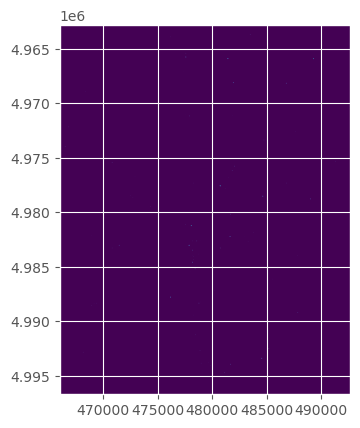

In [30]:
# Load rasterized emissions

from rasterio import plot

rast = rasterio.open(out_fn) # Open

plot.show(rast) # Plot it

emissions_band = rast.read(1)

rast.close()

In [35]:
emissions_band

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Get some sort of focal statistic? 
# We want cummulative impact! 

from scipy.ndimage import convolve # <- this is cool
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

# https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution
# Define weights kernel (tring gaussian?)

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)



kernel = gkern(200, 10) # 5 implies gaussian kernel with 125 meter diameter and sigma of 3

focal_mean = convolve(emissions_band, kernel) / np.sum(kernel)
focal_sum = convolve(emissions_band, kernel)

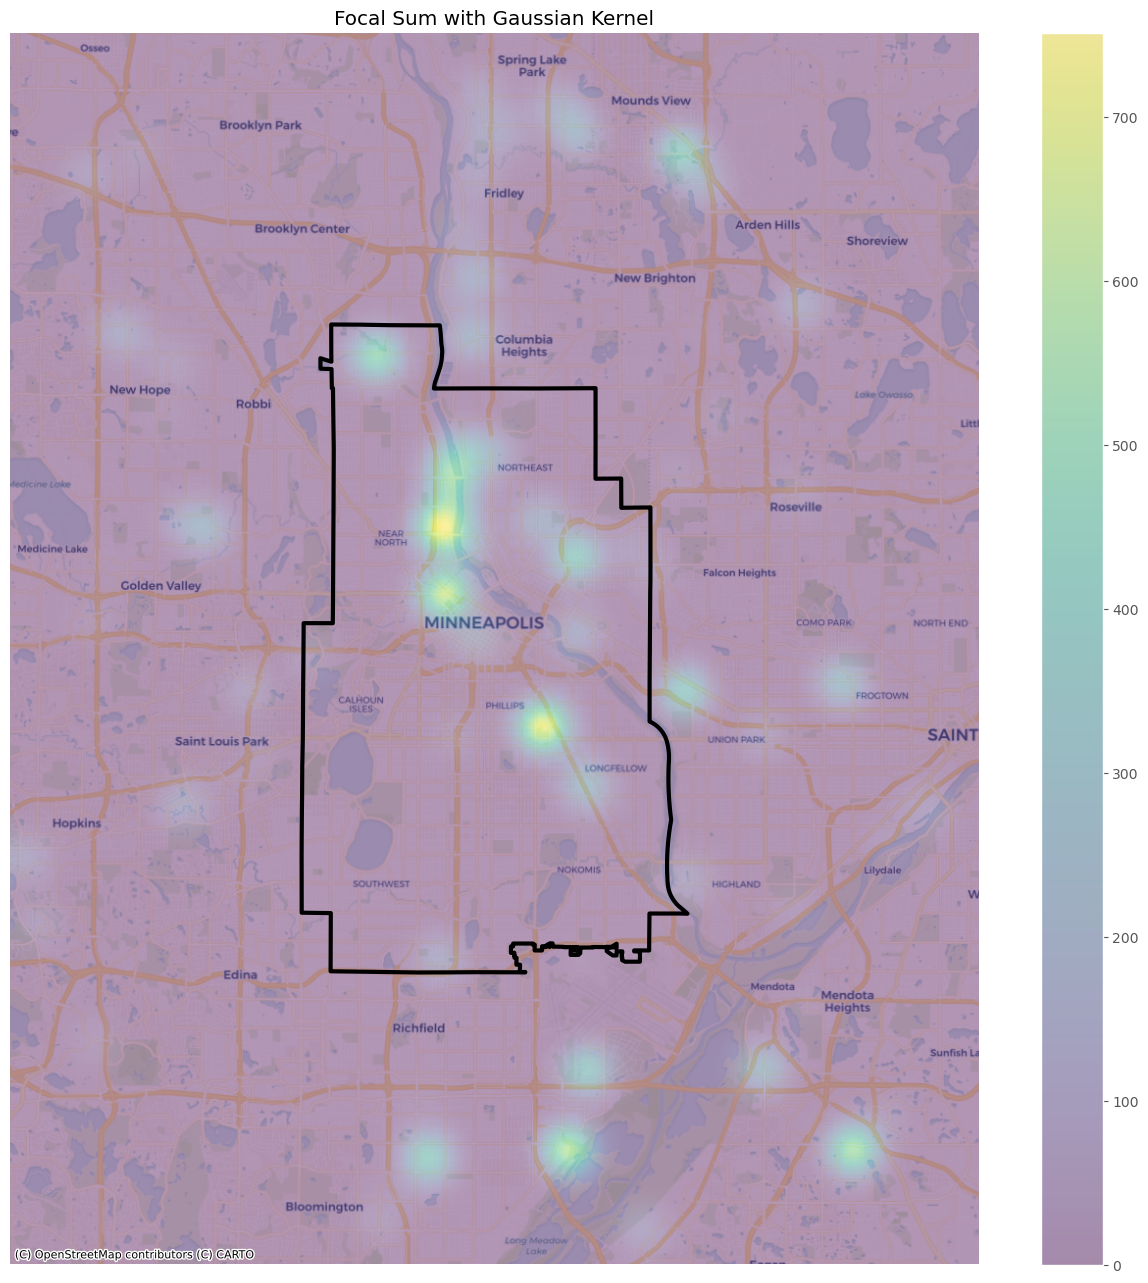

In [45]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], focal_sum.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Focal Sum with Gaussian Kernel'''
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 

plt.show()

In [106]:
# Now that's cumulative pm2.5 over the past 20 years or so.

# We can also do what it looks like today?

### Current

In [52]:
# Select Pollutant

# Interesting pollutants: 'Sulfur Dioxide', 'PM Primary', 'PM10 Primary', 'PM2.5 Primary',
# 'Volatile Organic Compounds', theres also all the dioxins... "Plastics"

current_emissions_select = emissions_select[emissions_select.YEAR == 2020]

pollutant_name = 'PM2.5 Primary'

pollutant_select = current_emissions_select[current_emissions_select.POLLUTANT == pollutant_name]

In [55]:
# Get filenames
rst_fn = 'template.tif'
out_fn = './rasterized_' + pollutant_name + '_current.tif'

# Get metadata from template
rst = rasterio.open(rst_fn) # Open template
meta = rst.meta.copy() # Copy template metadata
meta.update(compress='lzw') # Good for integers/categorical rasters
rst.close()

with rasterio.open(out_fn, 'w+', **meta) as out: # Burn features into raster
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(pollutant_select.geometry, pollutant_select.LBS_EMITTED))

    burned = features.rasterize(shapes=shapes, 
                                fill=0, 
                                out=out_arr, 
                                transform=out.transform,
                                merge_alg=rasterio.enums.MergeAlg.add) 
                                        # ^Cummulative emissions if facilities on top of eachother
    out.write_band(1, burned)

In [56]:
# Load rasterized emissions

from rasterio import plot

rast = rasterio.open(out_fn) # Open

emissions_band = rast.read(1)

rast.close()

In [57]:
# Get some sort of focal statistic? 
# We want cummulative impact! 

from scipy.ndimage import convolve # <- this is cool
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

# https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution
# Define weights kernel (tring gaussian?)

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)



kernel = gkern(200, 10) # 5 implies gaussian kernel with 125 meter diameter and sigma of 3

focal_mean = convolve(emissions_band, kernel) / np.sum(kernel)
focal_sum = convolve(emissions_band, kernel)

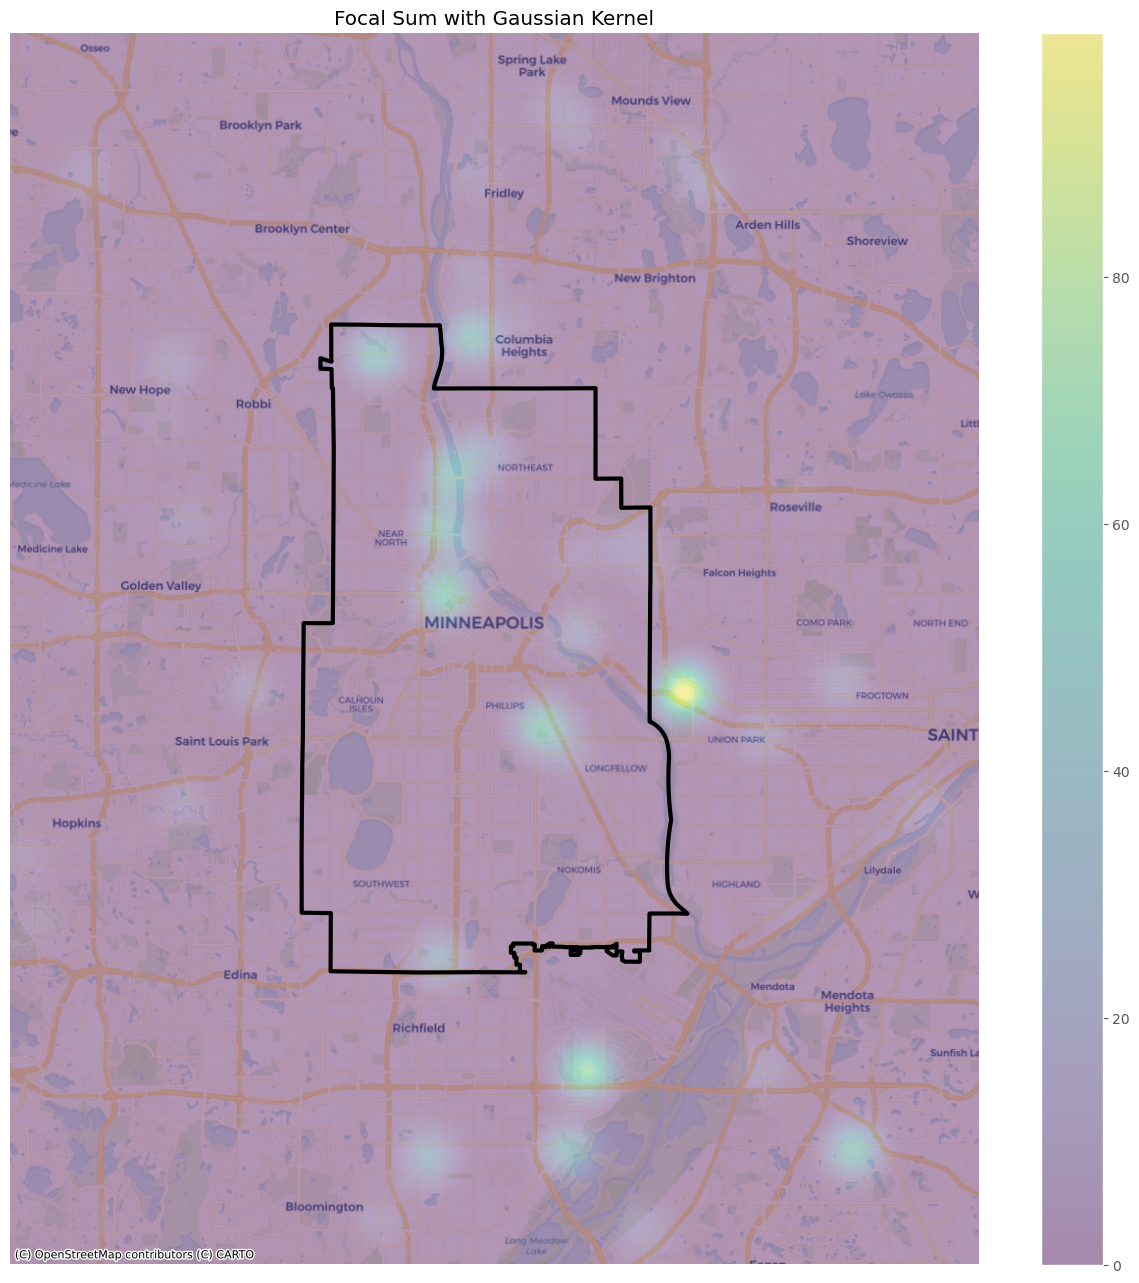

In [58]:
# PLOT!

f, ax = plt.subplots(1, figsize=(16,16)) # Initialize frame


art = ax.pcolormesh(raster[0], raster[1], focal_sum.T, shading='auto', cmap = 'viridis', alpha = 0.4) # Plot interpolation

f.colorbar(art, ax = ax) # Add colorbar
title = '''Focal Sum with Gaussian Kernel'''
ax.set_title(title) # Add title
ax.set_axis_off()

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Add basemap

contextily.add_basemap(ax = ax, 
                       crs = 'EPSG:26915', 
                       source=contextily.providers.CartoDB.Voyager
                      ) 

plt.show()

In [106]:
# Well, it looks a little better than before, huh
# This is just particulate matter 2.5, tho. There's way more!

In [ ]:
# Next to iterate through all the pollutants